In [ ]:
!pip install visualkeras
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
import tensorflow as tf
import visualkeras
from PIL import ImageFont
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 36.0 MB/s eta 0:00:00


In [ ]:
from google.colab import files
path_to_file = list(files.upload().keys())[0]

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
trainlabel = train['label']
train.head()
test.head()


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:

train['label'].value_counts(normalize=True)
df_train, df_val = train_test_split(train, test_size=0.25, random_state=69, stratify=train['label'])





In [ ]:
print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


In [ ]:


train[train['label'] == 1].head()


,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


In [ ]:
train[train['label'] == 0].head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


<Axes: >

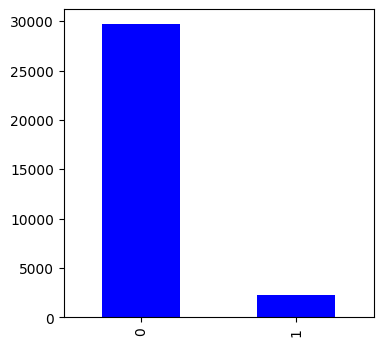

In [ ]:
train['label'].value_counts().plot.bar(color = 'blue' , figsize=(4,4))

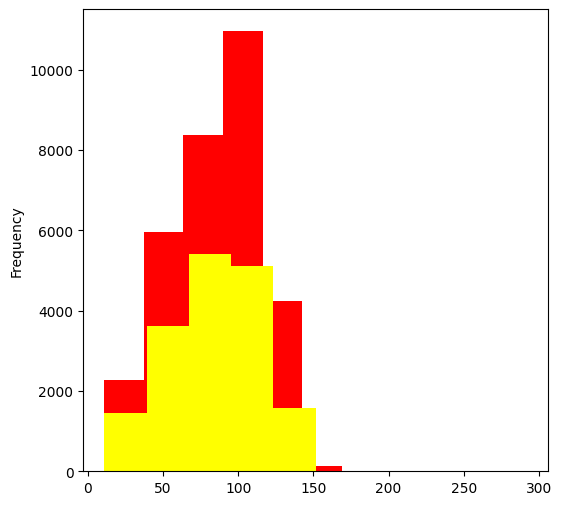

In [ ]:
length_train = train['tweet'].str.len().plot.hist(color = 'red' , figsize = (6,6))
length_test = test['tweet'].str.len().plot.hist(color = 'yellow' , figsize = (6,6))

In [ ]:
train['length'] = train['tweet'].str.len()
test['length']  = test['tweet'].str.len()

In [ ]:
train.head()

,id,label,tweet,length
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39


In [ ]:
test.head()

,id,tweet,length
0,31963,#studiolife #aislife #requires #passion #dedic...,90
1,31964,@user #white #supremacists want everyone to s...,101
2,31965,safe ways to heal your #acne!! #altwaystohe...,71
3,31966,is the hp and the cursed child book up for res...,142
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",93


<ipython-input-13-7d3dd8d9b03f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train.groupby('length').mean()['label'].plot.hist(color = 'violet' , figsize = (5,5))


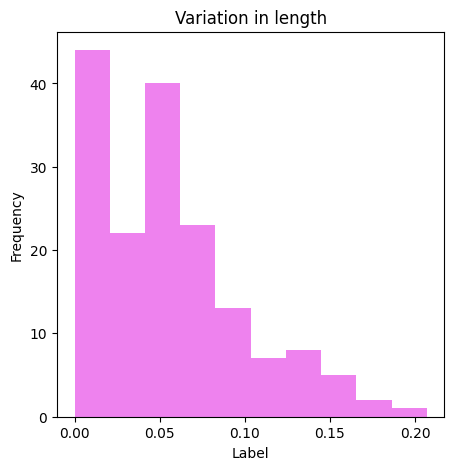

In [ ]:
train.groupby('length').mean()['label'].plot.hist(color = 'violet' , figsize = (5,5))
plt.title('Variation in length')
plt.xlabel('Label')
plt.show()

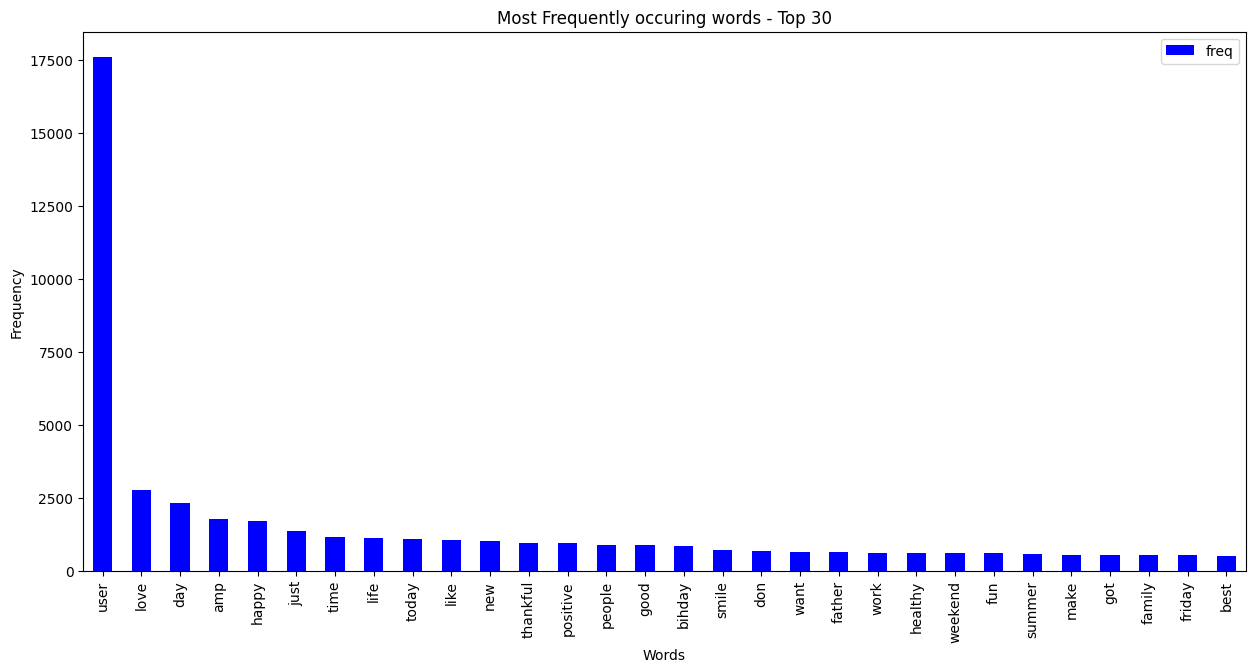

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis = 0)

words_freq = [(word, sum_words[0,i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15,7), color= "blue")
plt.title("Most Frequently occuring words - Top 30")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


In [ ]:
tokenized_tweet = train['tweet'].apply(lambda x: x.split())
import gensim
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tweet']), epochs=20)

In [ ]:
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
  review = review.lower()
  review = review.split()

  ps = PorterStemmer()

  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]

  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)


In [ ]:
test_corpus = []

for i in range(0, 17197):
  review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
  review = review.lower()
  review = review.split()

  ps = PorterStemmer()

  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]

  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)

(31962, 2500)
(31962,)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)


(17197, 2500)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23971, 2500)
(7991, 2500)
(23971,)
(7991,)


In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)
sc.fit_transform(x_train).shape

(23971, 2500)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)




Training Accuracy : 0.9851487213716574
Validation Accuracy : 0.9416843949443123
f1 score : 0.5933682373472949
[[7185  247]
 [ 219  340]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
